# Portfolio Optimization

## Main ideas
The goal of **portfolio optimization** is to optimally allocate the budget into different assets in order to obtain a *high return* with *low risk*.
The difficulty of portfolio optimization lies in the uncertainty of the future value of assets. 

For this problem, the decision is made at the *initial time* $t_{0}$ and the return is to be evaluated at the future *terminal time* $t_{1}$.
<!-- Let us focus on the pre-chosen $N$ assets, $a_{1},a_{2},\dots,a_{N}$, and suppose that we could estimate the *expected return* of the asset $a_{i}$ with $R_{i}$ (for all $i = 1,2,\dots,N$). 
Also suppose that we know the covariance between the expected return of assets $a_{i}$ and $a_{j}$ to be $\sigma_{ij}$.

Thus, the vector of expected returns of $a_{1},\dots,a_{N}$ is
$$
R = (R_{1},\dots,R_{N})
$$
and the corresponding covariance matrix is
$$
\Sigma = [\sigma_{ij}]_{i,j = 1,\dots,N} = 
\begin{bmatrix} \sigma_{11} & \sigma_{12} & \dots & \sigma_{1N} \\
\sigma_{21} & \sigma_{22} & \dots & \sigma_{2N} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{N1} & \sigma_{N2} & \dots & \sigma_{NN}
\end{bmatrix}.
$$ -->

## Problem setups
The problem starts with a pre-selected assets $a_{1},\dots,a_{N}$.

### Problem data
- The *expected return vector* $R = (R_{1},\dots,R_{N})$ where $R_{i}$ is the *expected return* of the asset $a_{i}$ at time $t_{1}$ compared to the initial time $t_{0}$.
- The corresponding *covariance matrix*
$$
\Sigma = [\sigma_{ij}]_{i,j = 1,\dots,N} = 
\begin{bmatrix} \sigma_{11} & \sigma_{12} & \dots & \sigma_{1N} \\
\sigma_{21} & \sigma_{22} & \dots & \sigma_{2N} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{N1} & \sigma_{N2} & \dots & \sigma_{NN}
\end{bmatrix},
$$
where $\sigma_{ij}$ denotes the *covariance* or the data behind $R_{i}$ and $R_{j}$.
Also note that $\sigma_{ij} = \sigma_{ji}$.

### Variables
- A *portfolio* $p = (p_{1},\dots,p_{N}) \in \mathbb{R}^{N}$, where $p_{i}$ is the proportion of the budget to be invested in $a_{i}$.

### Constraints
- The *budget* constraint: $\sum_{i=1}^{N} p_{i} = 1$.
- The *no-short-sales* constriant: $p_{i} \geq 0$ for all $i = 1,\dots,N$.

### Objectives
The objective of the problem is to gain *high expected return* with *low variance* (i.e. low risk). In practice, both would not occurs at the same time as a general rule-of-thumb: **high risk, high return**. Hence balancing between *return* and *risk* is the key in portfolio optimization:
$$
f(p) =  \underbrace{p^{T}\Sigma p}_{\text{risk}} - \eta \underbrace{R^{T}p}_{\text{expected return}} \quad\leftarrow \text{Minimize},
$$
where $\eta > 0$ is the *trade-off parameter*. It can be viewed that when $\eta$ gets larger, the optimal portfolio becomes more risky.

### Portfolio optimization
With a fixed trade-off $\eta > 0$, the corresponding portfolio optimization is defined by
$$
\begin{array}{rl}
\min & \displaystyle p^{T}\Sigma p - \eta R^{T}p = \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_{ij}p_{i}p_{j} - \eta\sum_{i=1}^{N} R_{i}p_{i} \\
\text{s.t.} & \displaystyle \sum_{i=1}^{N} p_{i} = 1 \\
& p_{i} \geq 0 \quad (i = 1,\dots,N).
\end{array}
$$

---

## First example

Find an optimal portfolio invested into two assets $A$ and $B$ with the following statistics:

| $R_{A}$ | $R_{B}$ | $\sigma_{AA}$ | $\sigma_{BB}$ | $\sigma_{AB} = \sigma_{BA}$ |
|:---:|:---:|:---:|:---:|:---:|
| 0.175 | 0.055 | 0.067 | 0.013 | -0.005 |

In [1]:
from pyscipopt import Model, quicksum
import numpy as np

In [2]:
# Data
R = np.array([.175, .055])
Sigma = np.array([[.067, -.005], [-.005, .013]])

# Trade-off parameter
eta = .5

# Create the model
port = Model("Portfolio optimization for two assets")

# Add variables and constraints
p = [port.addVar(vtype='C', lb=0, ub=None, name=f"p_{i}") for i in range(2)]
port.addCons(quicksum(p[i] for i in range(2)) == 1, name="budget")

# The objective is Nonlinear. We need the following TRICK.
obj = port.addVar(vtype='C', lb=None, ub=None, name='objective value')
port.addCons(obj >= quicksum(Sigma[i][j]*p[i]*p[j] for i in range(2) for j in range(2)) 
             - eta*quicksum(R[i]*p[i] for i in range(2)))
port.setObjective(obj, sense="minimize")

In [3]:
port.hideOutput()
port.optimize()

In [4]:
SOL = port.getBestSol()
Port = np.array(2*[None])
for i in range(2):
    Port[i] = SOL[p[i]]
Return = np.dot(R,Port)
Variance = np.dot(Port,np.dot(Sigma,Port))

print(f"Optimal portfolio\nInvestment in Asset A: = {Port[0]}\nInvestment in Asset B: {Port[1]}")
print(f"Expected return of this portfolio = {Return}")
print(f"Variance of this portfolio = {Variance}")

Optimal portfolio
Investment in Asset A: = 0.5333333300400662
Investment in Asset B: 0.4666666699599338
Expected return of this portfolio = 0.11899999960480795
Variance of this portfolio = 0.019399999802403974


---

## The efficient frontier

In practice, we do not know what

Let us resolve the above problem at different trade-off parameters $\eta = 0.02,0.04,\dots,1$, and collect their solutions.

In [5]:
Etas = np.arange(0.02,1.01,0.02)
cases = np.shape(Etas)[0]
P = cases * [None]
Ret = cases * [None]
Var = cases * [None]

# Data
R = np.array([0.175, 0.055])
Sigma = np.array([[0.067, -0.005], [-0.005, 0.013]])

for e in range(cases):
    eta = Etas[e]

    # Create the model
    port = Model("Portfolio optimization for two assets")
    
    # Add variables and constraints
    p = [None for i in range(2)]
    for i in range(2):
        p[i] = port.addVar(vtype='C', lb=0, ub=None, name=f"p_{i}")
    port.addCons(quicksum(p[i] for i in range(2)) == 1, name="budget")
    
    # The objective is Nonlinear. We need the following TRICK.
    obj = port.addVar(vtype='C', lb=None, ub=None, name='objective value')
    port.addCons(obj >= quicksum(Sigma[i][j]*p[i]*p[j] for i in range(2) for j in range(2)) 
             - eta*quicksum(R[i]*p[i] for i in range(2)))
    port.setObjective(obj, sense="minimize")

    # Solve
    port.hideOutput()
    port.optimize()

    # Collect solutions
    SOL = port.getBestSol()
    Port = np.array(2*[None])
    for i in range(2):
        Port[i] = SOL[p[i]]
    P[e] = Port
    Ret[e] = np.dot(R,P[e])
    Var[e] = np.dot(P[e],np.dot(Sigma,P[e]))
    print(f"eta={eta}, Portfolio={P[e]}, Expected Return={Ret[e]}, Variance={Var[e]}")



eta=0.02, Portfolio=[0.21333333764752238 0.7866666623524776], Expected Return=0.08060000051770269, Variance=0.009416000010354055
eta=0.04, Portfolio=[0.22666667531820361 0.7733333246817964], Expected Return=0.08220000103818442, Variance=0.009464000041527382
eta=0.06, Portfolio=[0.24000004020945176 0.7599999597905482], Expected Return=0.08380000482513421, Variance=0.009544000289508199
eta=0.08, Portfolio=[0.2533333464490408 0.7466666535509592], Expected Return=0.08540000157388489, Variance=0.009656000125910807
eta=0.1, Portfolio=[0.2666666959773295 0.7333333040226705], Expected Return=0.08700000351727954, Variance=0.009800000351728032
eta=0.12000000000000001, Portfolio=[0.28000001589489565 0.7199999841051044], Expected Return=0.08860000190738748, Variance=0.00997600022888652
eta=0.13999999999999999, Portfolio=[0.2933333100841836 0.7066666899158164], Expected Return=0.09019999721010202, Variance=0.010183999609414334
eta=0.16, Portfolio=[0.30666664309538283 0.6933333569046172], Expected R

In [6]:
import matplotlib.pyplot as plt

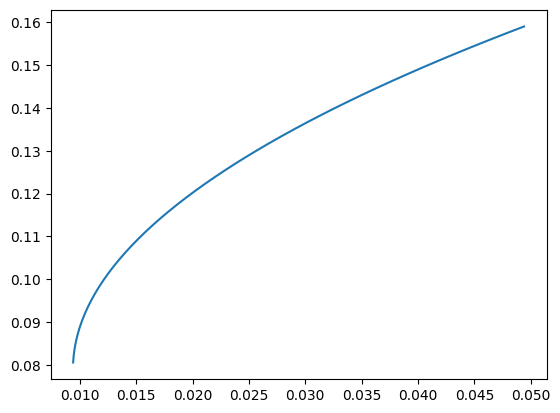

In [8]:
plt.plot(Var,Ret)
plt.show()

---